In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import warnings
import nltk
warnings.filterwarnings("ignore")
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import gutenberg as cg
# sentence tokeniser
from nltk.tokenize import word_tokenize as wt 
from collections import Counter
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textblob
import gensim
import tweepy
import re
import spacy

### **Authentification**

In [314]:
# removing the new line characters
with open('auth_keys.txt') as f:
    lines = [line.rstrip() for line in f]
Consumer_Key = lines[0]
Consumer_Secret = lines[1]
Bearer_Token = lines[2]
Access_Token = lines[3]
Access_Secret = lines[4]

In [3]:
# https://towardsdatascience.com/social-media-sentiment-analysis-in-python-with-vader-no-training-required-4bc6a21e87b8
# https://vadersentiment.readthedocs.io/en/latest/index.html

# Messing with Vader
analyzer = SentimentIntensityAnalyzer()
print(analyzer.polarity_scores('Terrible and useless device'))

{'neg': 0.747, 'neu': 0.253, 'pos': 0.0, 'compound': -0.7096}


In [7]:
client = tweepy.Client(Bearer_Token)

### **Scraping the Tweets**

In [32]:
method_use = client.search_recent_tweets # method to use
query = '#monkeypox #health OR #covid health -is:retweet lang:en'
count = 100 # 100 tweets per page
limit = 10 # Number of pages

In [ ]:
# Using paginator
paginator = tweepy.Paginator(method_use,
                            query=query,
                            max_results=count,
                            limit=limit)

tweet_list = []
for tweet in paginator.flatten(): # Total number of tweets to retrieve
    tweet_list.append(tweet)
    print(tweet)

In [ ]:
for tweet in paginator.flatten(): # Total number of tweets to retrieve
    print(tweet.text)

In [35]:
# Creating new dataframe and new features
df = pd.DataFrame(tweet_list)

In [42]:
df_text = pd.DataFrame(df.text) # to make it a dataframe

In [57]:
df_text.head(5)

,text
0,"No thank you! ""The new vaccine combines the ex..."
1,📃 #ScientificResearch: \nSafety and Efficacy o...
2,"DCP #FireExtinguisher for all Classes \n6kg, 4..."
3,RT @Dev_Discourse: Health News Roundup: Vietna...
4,Health News Roundup: Vietnam reports first cas...


In [56]:
df_string  = df_text.head(5)

### **Data Preprocessing**

#### **Testing something**

In [55]:
import string
# Understanding translate & str.maketrans
# https://medium.com/analytics-vidhya/when-and-where-to-use-maketrans-and-translate-in-python-764670ff91fe
# https://datagy.io/python-remove-punctuation-from-string/#:~:text=One%20of%20the%20easiest%20ways,maketrans()%20method.

a_string = '!hi. wh?at is the weat[h]er lik?e.'
a_string2 = ['!hi. wh?at is the weat[h]er lik?e.','!hi. wh?at is the weat[h]er@@@?!!! lik?e.']
new_string = a_string.translate(str.maketrans('', '', string.punctuation))

print(new_string)

# Returns: hi what is the weather like

hi what is the weather like


In [54]:
new_string = []
for a in a_string2:
    new_a = a.translate(str.maketrans('', '', string.punctuation))
    new_string.append(new_a)
print(new_string)

['hi what is the weather like', 'hi what is the weather like']


In [58]:
cleaned = []
for tweet in df_string.text:
    cleaned_ = tweet.translate(str.maketrans('', '', string.punctuation))
    cleaned.append(cleaned_)

In [66]:
df_string[:1].to_string()

'                                                                                                                                                                                                     text\n0  No thank you! "The new vaccine combines the experimental #flu shot that is furthest along with its #COVID-19 #vaccine." #Health #medicine #Moderna #conspiracy #WakeupAmerica\\nhttps://t.co/CUGAtWY8ep'

In [65]:
cleaned[0]

'No thank you The new vaccine combines the experimental flu shot that is furthest along with its COVID19 vaccine Health medicine Moderna conspiracy WakeupAmerica\nhttpstcoCUGAtWY8ep'

### **Data Preprocessing continued**

In [90]:
# https://stackoverflow.com/questions/12851791/removing-numbers-from-string
def preprocess_tweets(sent):
    '''Cleans text data up, leaving only 2 or
        more char long non-stepwords composed of A-Z & a-z only
        in lowercase'''
    # lowercase
    sentence = sent.lower()

    # Remove RT
    sentence = re.sub('RT @\w+: '," ",sentence)

    # Remove special characters
    sentence = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence)

    # Removing digits
    sentence = sentence.translate(str.maketrans('', '', string.digits))

    # Removing puntuactions
    # sentence = sentence.translate(str.maketrans('', '', string.punctuation))

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  
    # When we remove apostrophe from the word "Mark's", 
    # the apostrophe is replaced by an empty space. 
    # Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  
    # Next, we remove all the single characters and replace it by a space 
    # which creates multiple spaces in our text. 
    # Finally, we remove the multiple spaces from our text as well.

    return sentence


In [91]:
cleaned_tweets = [] # A new list for cleaned tweets

for tweet in df_text['text']:
    cleaned_tweet = preprocess_tweets(tweet)
    cleaned_tweets.append(cleaned_tweet)

In [92]:
print(cleaned_tweets[1]) # with remove digits

# When didn't remove digits:
#  scientificresearch safety 
# and efficacy of 
# dupilumab for the 
# treatment of hospitalized
#  patients with moderate to severe covid science health 
# medical study research covid19 sarscov2

 scientificresearch safety and efficacy of dupilumab for the treatment of hospitalized patients with moderate to severe covid science health medical study research covid sarscov 


In [97]:
df_text['cleaned'] = pd.DataFrame(cleaned_tweets)
df_text.head(5)

,text,cleaned
0,"No thank you! ""The new vaccine combines the ex...",no thank you the new vaccine combines the expe...
1,📃 #ScientificResearch: \nSafety and Efficacy o...,scientificresearch safety and efficacy of dup...
2,"DCP #FireExtinguisher for all Classes \n6kg, 4...",dcp fireextinguisher for all classes kg kg kg ...
3,RT @Dev_Discourse: Health News Roundup: Vietna...,rt discourse health news roundup vietnam repor...
4,Health News Roundup: Vietnam reports first cas...,health news roundup vietnam reports first case...


### **Tokenise, POS-tagging and Lemmatisation**

<!-- https://towardsdatascience.com/an-short-introduction-to-vader-3f3860208d53 -->
There is a URL here, click to find out

**Preprocessing. Nope.**

The incredible thing about VADER is it doesn’t require a great deal of preprocessing to work. Unlike with some supervised methods of NLP, preprocessing necessities such as tokenisation and stemming/lemmatisation are not required. You can pretty much plug in any body of text and it will determine the sentiment.

## **Generating Sentiment Labels**

### **IT IS TIME FOR VADER!!!**

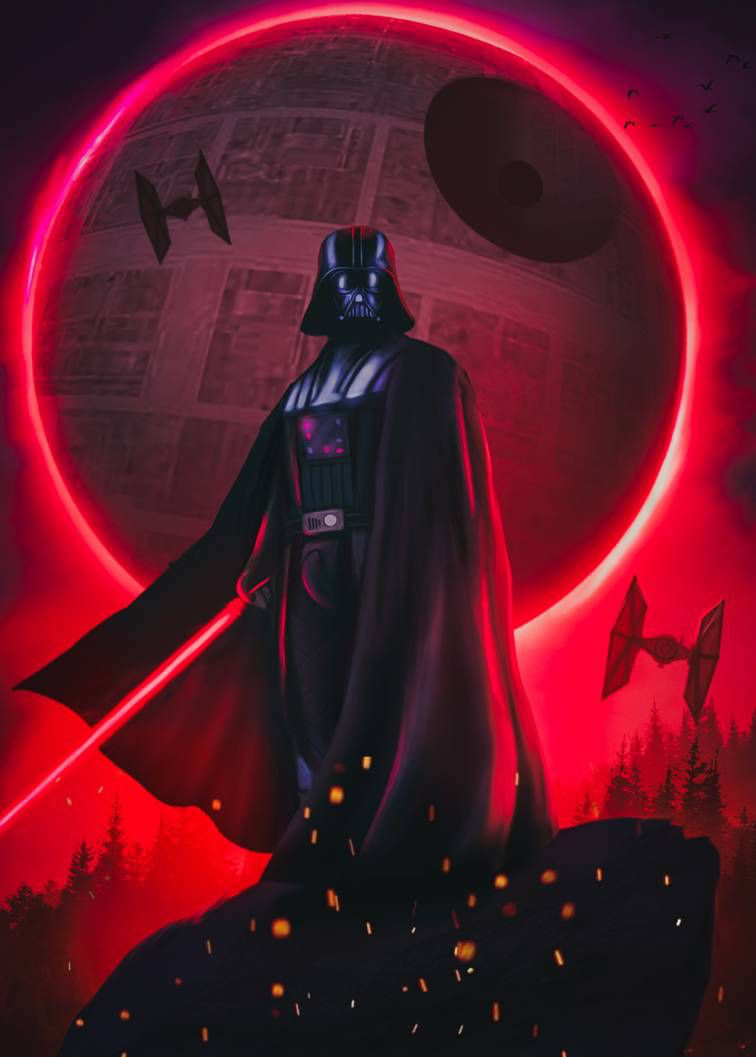

In [164]:
from PIL import Image
img =Image.open("img/darth_vader_1.jpg")
img


<!-- https://www.quora.com/What-is-polarity-and-subjectivity-in-sentiment-analysis -->
There is a URL here, click to find out

**Polarity** 

Refers to the strength of an opinion. It could be positive or negative. If something has a strong positive feeling or emotion associated with it, such as admiration, trust, love; this will indeed have a certain orientation towards all other aspects of that object’s existence. The same goes for negative polarities. A good example would be the following: ‘I don’t think I’ll buy this item because my previous experience with a similar item wasn’t so good.’ That will have a negative polarity.

The strength of positive and negative polarities can vary depending on the situation, but they are still considered to be strongly positive or negative. What about weak sentiment? It is common for users to express their emotions using words like ‘quite’ or ‘slightly’. Sentiment analysis tools would treat them as slightly positive or negative. What matters most here is what people feel about something else through non-verbal communication. The use of these words might indicate how much they value an object in a subjective way or not; therefore, subjectivity comes into play here as well.

**Subjectivity** 

Refers to the degree to which a person is personally involved in an object. What matters the most here are personal connections and individual experiences with that object, which may or may not differ from someone else’s point of view. For example: ‘I’m very happy with my new smartphone because it has the highest performance available on the market.’ Similarly to polarity, strong subjectivity may be negative or positive. The statement here is clearly subjective because the user is actually talking about his experience and how he feels about an object.

Sentiment analysis tools must be able to distinguish between both polarity and subjectivity in order to analyze users’ opinions correctly. An opinion can have a high degree of subjectivity if it’s expressed as a personal experience, whereas a low degree may indicate someone else’s viewpoint on something else. Sentiments can also have different levels of polarity throughout different ways of communication – e-mails, chats or other posts might be either strongly positive, negative or; in some other cases, they might have even a neutral polarity.

In [101]:
df_text.loc[:3,'cleaned'] # Slicing
df_text.loc[4,'cleaned'] # Selecting each index

'health news roundup vietnam reports first case of monkeypox state media bubs australia seeks permanent market access from fda and more health covid monkeypox fda vaccine corona'

In [104]:
# https://textblob.readthedocs.io/en/dev/api_reference.html

#Calculating Negative, Positive, Neutral and Compound values

analyzer = SentimentIntensityAnalyzer()

df_text[['polarity','subjectivity']] = (df_text.cleaned.apply
                                            (lambda x: pd.Series(textblob.TextBlob
                                            (x).sentiment)))

for index,row in enumerate(df_text['cleaned']):
    score = analyzer.polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    compound = score['compound']
    if compound <= -0.5:
        df_text.loc[index, 'sentiment'] = "negative" # making new columns are appending the values; negative,etc 
    elif compound >= 0.5:
        df_text.loc[index, 'sentiment'] = "positive"
    else:
        df_text.loc[index, 'sentiment'] = "neutral"
    # Appending the score values to the columns
    df_text.loc[index, 'neg'] = neg
    df_text.loc[index, 'neu'] = neu
    df_text.loc[index, 'pos'] = pos
    df_text.loc[index, 'compound'] = compound

In [105]:
df_text.head(5)

,text,cleaned,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,"No thank you! ""The new vaccine combines the ex...",no thank you the new vaccine combines the expe...,0.118182,0.427273,negative,0.279,0.721,0.000,-0.7970
1,📃 #ScientificResearch: \nSafety and Efficacy o...,scientificresearch safety and efficacy of dup...,0.000000,0.350000,neutral,0.095,0.803,0.102,0.0516
2,"DCP #FireExtinguisher for all Classes \n6kg, 4...",dcp fireextinguisher for all classes kg kg kg ...,0.466667,0.466667,positive,0.061,0.732,0.207,0.7003
3,RT @Dev_Discourse: Health News Roundup: Vietna...,rt discourse health news roundup vietnam repor...,0.250000,0.333333,neutral,0.000,1.000,0.000,0.0000
4,Health News Roundup: Vietnam reports first cas...,health news roundup vietnam reports first case...,0.375000,0.416667,neutral,0.000,1.000,0.000,0.0000


Based off the VADER documentations

positive sentiment: compound score >= 0.5

neutral sentiment: (compound score > -0.5) and (compound score < 0.5)

negative sentiment: compound score <= -0.5

### **Sentiment Visaulisation**

In [110]:
# Creating new data frames for all sentiments (positive, negative and neutral)
# Using different versions of passing the dataframe

# df_negative = df_text.loc[df_text['sentiment'] == 'negative', 'sentiment'] # Using loc & using "." operator
# df_negative = df_text[df_text.sentiment == 'negative'] # passing dataframes
# df_positive = df_text[df_text.sentiment == 'positive'] # passing dataframes using "." operator
# df_neutral= df_text[df_text['sentiment'] == 'neutral'] # passing dataframes
## df_neutral= df_text.loc[df_text['sentiment'] == 'neutral','sentiment'] # Using loc & using [] operator

In [133]:
# sentiment_mapping = {'negative':-1,'neutral':0,'positive':1}
# df_text['sentiment_label_values'] = df_text.sentiment.map(sentiment_mapping)
# df_text.drop(columns=['sentiment_label_values'],inplace=True)
# Refer to "veh_copy_git" project

In [ ]:
# For WORDCLOUD
df_negative = df_text[df_text.sentiment == 'negative'] # passing dataframes
df_positive = df_text[df_text.sentiment == 'positive'] # passing dataframes using "." operator
df_neutral= df_text[df_text['sentiment'] == 'neutral'] # passing dataframes

In [134]:
# For Pie Chart
df_sentiment = df_text['sentiment'].value_counts()
df_sentiment= df_sentiment.to_frame().reset_index()
df_sentiment.rename(columns={'index':'sentiment','sentiment':'total_count'}, inplace=True)
df_sentiment

,sentiment,total_count
0,neutral,606
1,negative,219
2,positive,175


### **Generating Pie Chart**

In [163]:
import plotly.graph_objects as go

# fig = px.pie(df_sentiment, values='total_count', names='sentiment', title='SEGEMENATION OF SENTIMENTS')
# fig = px.pie(df_sentiment, values='total_count', names='sentiment', title='SEGEMENATION OF SENTIMENTS',hole=.2) # DONUT 
# fig.show()

# Refer to "olympics_2020"
# https://plotly.com/python/reference/layout/#layout-transition
# https://plotly.com/python/reference/pie/
# A more styled Pie Chart
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']

fig = go.Figure(data=[go.Pie(labels=df_sentiment.sentiment,
                             values=df_sentiment.total_count)])


fig.update_layout(
width=1000,
title={"x": 0.5, "xanchor":"center", 
"font_family":"Times New Roman", 
"text":"SEGEMENATION OF SENTIMENTS"})

fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker={'colors':colors, 'line_color':'#000000','line_width':2})

fig.show()



### **Word Clouds**

In [227]:
df_text

,text,cleaned,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,"No thank you! ""The new vaccine combines the ex...",no thank you the new vaccine combines the expe...,0.118182,0.427273,negative,0.279,0.721,0.000,-0.7970
1,📃 #ScientificResearch: \nSafety and Efficacy o...,scientificresearch safety and efficacy of dup...,0.000000,0.350000,neutral,0.095,0.803,0.102,0.0516
2,"DCP #FireExtinguisher for all Classes \n6kg, 4...",dcp fireextinguisher for all classes kg kg kg ...,0.466667,0.466667,positive,0.061,0.732,0.207,0.7003
3,RT @Dev_Discourse: Health News Roundup: Vietna...,rt discourse health news roundup vietnam repor...,0.250000,0.333333,neutral,0.000,1.000,0.000,0.0000
4,Health News Roundup: Vietnam reports first cas...,health news roundup vietnam reports first case...,0.375000,0.416667,neutral,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...
995,📃 #ScientificResearch: Health behaviour change...,scientificresearch health behaviour change am...,0.000000,0.000000,negative,0.161,0.839,0.000,-0.6597
996,‼️ Americans are now more worried about their ...,americans are now more worried about their me...,0.290909,0.388745,neutral,0.063,0.891,0.046,-0.1761
997,"If you are in need of #COVID resources, the Ci...",if you are in need of covid resources the city...,0.500000,0.900000,neutral,0.000,1.000,0.000,0.0000
998,Fauci admit his lockdowns had negative consequ...,fauci admit his lockdowns had negative consequ...,-0.300000,0.400000,neutral,0.211,0.686,0.103,-0.4404


In [282]:
from wordcloud import ImageColorGenerator

In [293]:
mask = np.array(Image.open('img/cloud.png'))
def create_wordcloud(data,column):
    stopwords = set(STOPWORDS)
    wc = WordCloud( max_font_size=40,
                            # background_color='white',
                            max_words=100,                        
                            stopwords=stopwords,
                            mask=mask,
                            margin=10,
                            random_state=42,
                            repeat=True)
                         
    wc.generate(str(data[column].values))
    wc.to_file(f"img/{column}.png")
    print(f"Word Cloud for {column} saved successfully")
    path = f'img/{column}.png'
    display(Image.open(path))

Word Cloud for cleaned saved successfully


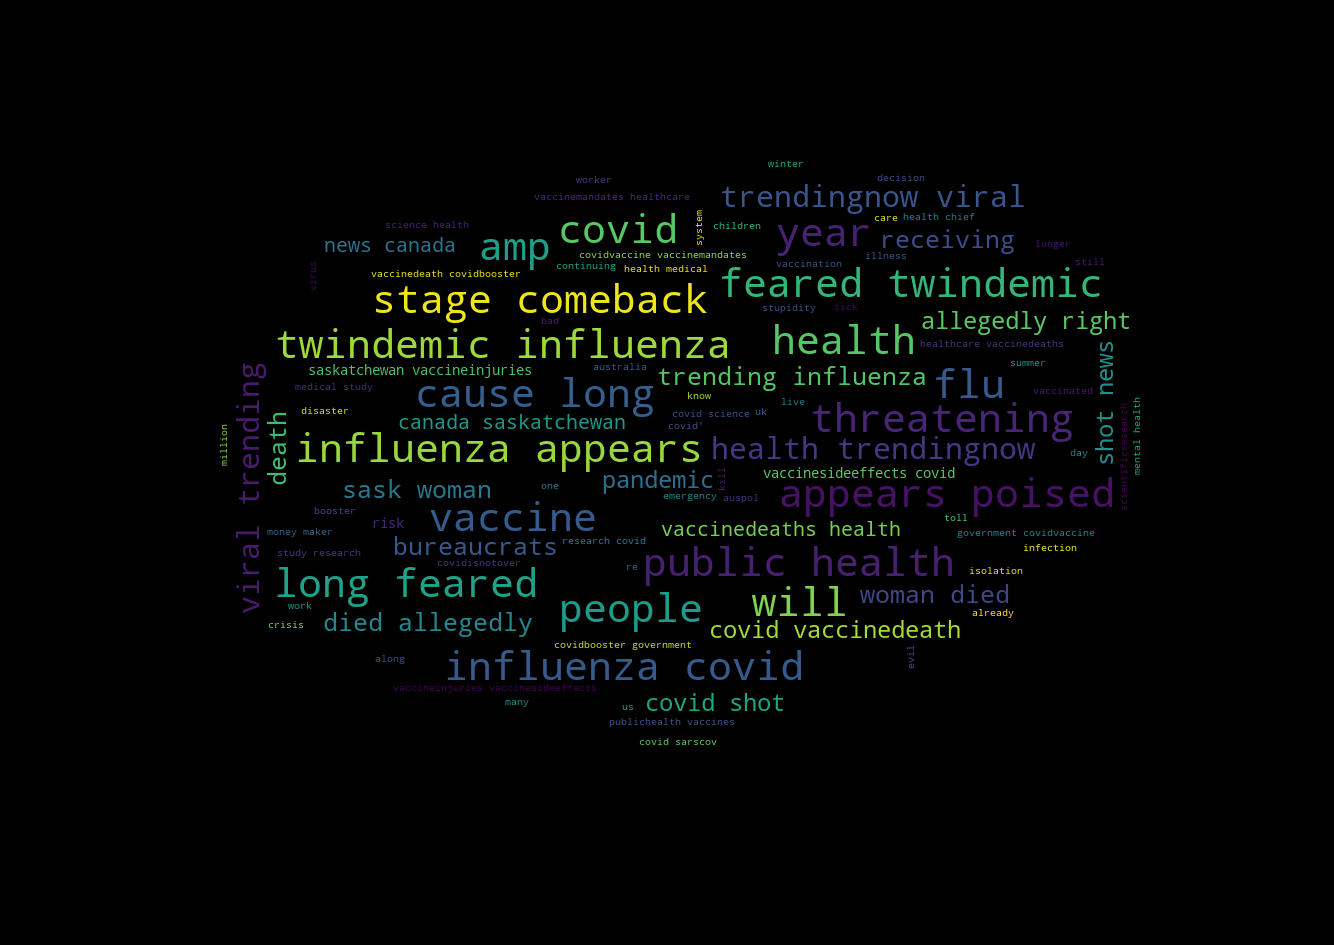

In [304]:
# Creating wordcloud
# create_wordcloud(df_text,'cleaned')
# create_wordcloud(df_neutral,'cleaned')
# create_wordcloud(df_positive,'cleaned')
create_wordcloud(df_negative,'cleaned')

In [299]:
# text = df_text.loc[df_text['sentiment']=='negative','cleaned']
# if text.empty:
#     print("EMPTY")
# else:
#     print(text.head())

In [300]:
# mask = np.array(Image.open('img/cloud.png'))
# def create_wordcloud2(column):
#     stopwords = set(STOPWORDS)
#     wc = WordCloud( max_font_size=40,
#                             # background_color='white',
#                             max_words=100,                        
#                             stopwords=stopwords,
#                             mask=mask,
#                             margin=10,
#                             random_state=42,
#                             repeat=True)
#     text = df_text.loc[df_text['sentiment']==column,'cleaned']
#     # while text.empty:
#     #     print("Supply a valid sentiment > ")
#     #     submit = input(">> " )
#     #     create_wordcloud2(submit)
#     #     break

#     wc.generate(str(text))
#     wc.to_file(f"img/{column}.png")
#     print(f"Word Cloud for {column} saved successfully")
#     path = f'img/{column}.png'
#     display(Image.open(path))

# # print("Supply a valid sentiment > ")
# # submit = input(">> " )
# create_wordcloud2('neutral')

In [301]:
# # mask = np.array(Image.open('img/alice_2.png'))
# mask = np.array(Image.open('img/star_wars_helmet.jpg'))
# stopwords = set(STOPWORDS)
# wc = WordCloud( #max_font_size=40,
#                 background_color='white',
#                 max_words=2000,                      
#                 stopwords=stopwords,
#                 mask=mask,
#                 margin=10,
#                 random_state=30,
#                 repeat=True)

# # create coloring from image
# image_colors = ImageColorGenerator(mask)
# wc.generate(str(df_text['cleaned'].values))

# # fig,ax = plt.subplots(1, figsize=(20,10))
# # ax.imshow(wc,interpolation='bilinear')
# # plt.show()

# # show
# fig, ax = plt.subplots(1,3, figsize=(20,10))
# ax[0].imshow(wc, interpolation="bilinear")
# # recolor wordcloud and show
# # we could also give color_func=image_colors directly in the constructor
# ax[1].imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
# ax[2].imshow(mask, cmap=plt.cm.gray, interpolation="bilinear")
# for ax in ax:
#     ax.set_axis_off()
# plt.show()

#### **Exporting**

In [311]:
sentiment_mapping = {'negative':-1,'neutral':0,'positive':1}
df_text['sentiment_label_values'] = df_text.sentiment.map(sentiment_mapping)
# df_text.drop(columns=['sentiment_label_values'],inplace=True)
# Refer to "veh_copy_git" project

In [312]:
df_text

,text,cleaned,polarity,subjectivity,sentiment,neg,neu,pos,compound,sentiment_label_values
0,"No thank you! ""The new vaccine combines the ex...",no thank you the new vaccine combines the expe...,0.118182,0.427273,negative,0.279,0.721,0.000,-0.7970,-1
1,📃 #ScientificResearch: \nSafety and Efficacy o...,scientificresearch safety and efficacy of dup...,0.000000,0.350000,neutral,0.095,0.803,0.102,0.0516,0
2,"DCP #FireExtinguisher for all Classes \n6kg, 4...",dcp fireextinguisher for all classes kg kg kg ...,0.466667,0.466667,positive,0.061,0.732,0.207,0.7003,1
3,RT @Dev_Discourse: Health News Roundup: Vietna...,rt discourse health news roundup vietnam repor...,0.250000,0.333333,neutral,0.000,1.000,0.000,0.0000,0
4,Health News Roundup: Vietnam reports first cas...,health news roundup vietnam reports first case...,0.375000,0.416667,neutral,0.000,1.000,0.000,0.0000,0
...,...,...,...,...,...,...,...,...,...,...
995,📃 #ScientificResearch: Health behaviour change...,scientificresearch health behaviour change am...,0.000000,0.000000,negative,0.161,0.839,0.000,-0.6597,-1
996,‼️ Americans are now more worried about their ...,americans are now more worried about their me...,0.290909,0.388745,neutral,0.063,0.891,0.046,-0.1761,0
997,"If you are in need of #COVID resources, the Ci...",if you are in need of covid resources the city...,0.500000,0.900000,neutral,0.000,1.000,0.000,0.0000,0
998,Fauci admit his lockdowns had negative consequ...,fauci admit his lockdowns had negative consequ...,-0.300000,0.400000,neutral,0.211,0.686,0.103,-0.4404,0


In [313]:
df_text[['cleaned','sentiment','sentiment_label_values']].to_csv('cleaned.csv',index=False)